## Import modules

In [1]:
import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'
# numpy is used for generating, storing, and plotting data
import numpy as np
# zfit will be used for the parameter estimation in the following
import zfit
import uproot

# in order to visualise the results of the computation, we use matplotlib
import matplotlib as mpl
if os.path.exists('lhcbStylerc'):
    mpl.rc_file('lhcbStylerc') # some plotting presets i usually use, you can find them in the git-repo
import socket
#if 'jupyter-schmitse-' in socket.gethostname():
#    mpl.rcParams['text.usetex'] = False # no latex on binder
    
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.LHCb2)
#plt.rcParams['text.usetex'] = True
# for histograms boost has an easy api and is very fast
import hist
# for statistical distributions we can use a lot from scipy
from scipy import stats

### Open ntuple

In [2]:
path = '/afs/cern.ch/user/p/pgaigne/xiccpp/Xicc/TMVA/job31-CombDVntuple-full-evts-TMVA.root'
#path = "/eos/lhcb/user/p/pgaigne/job30-CombDVntuple-95%-evts-0-Xicc-TMVA.root"

file =  uproot.open(path)
tree = file['DecayTree']

branches_we_want = ["Xicc_M","Xicc_M_DTF_Lc","Lc_M","BDT","BDTG","MLP"] 
data_df = tree.arrays(expressions = branches_we_want, library='pd')

file.close()


# note, these are the maximum likelihood estimators for both the 
# mean of a distribution and the variance (std = sqrt(variance))
# create a sample with size 3000 that follow a normal distribution
zfit.settings.set_seed(1337)
gen = np.random.default_rng(seed=1337)

## BDT response

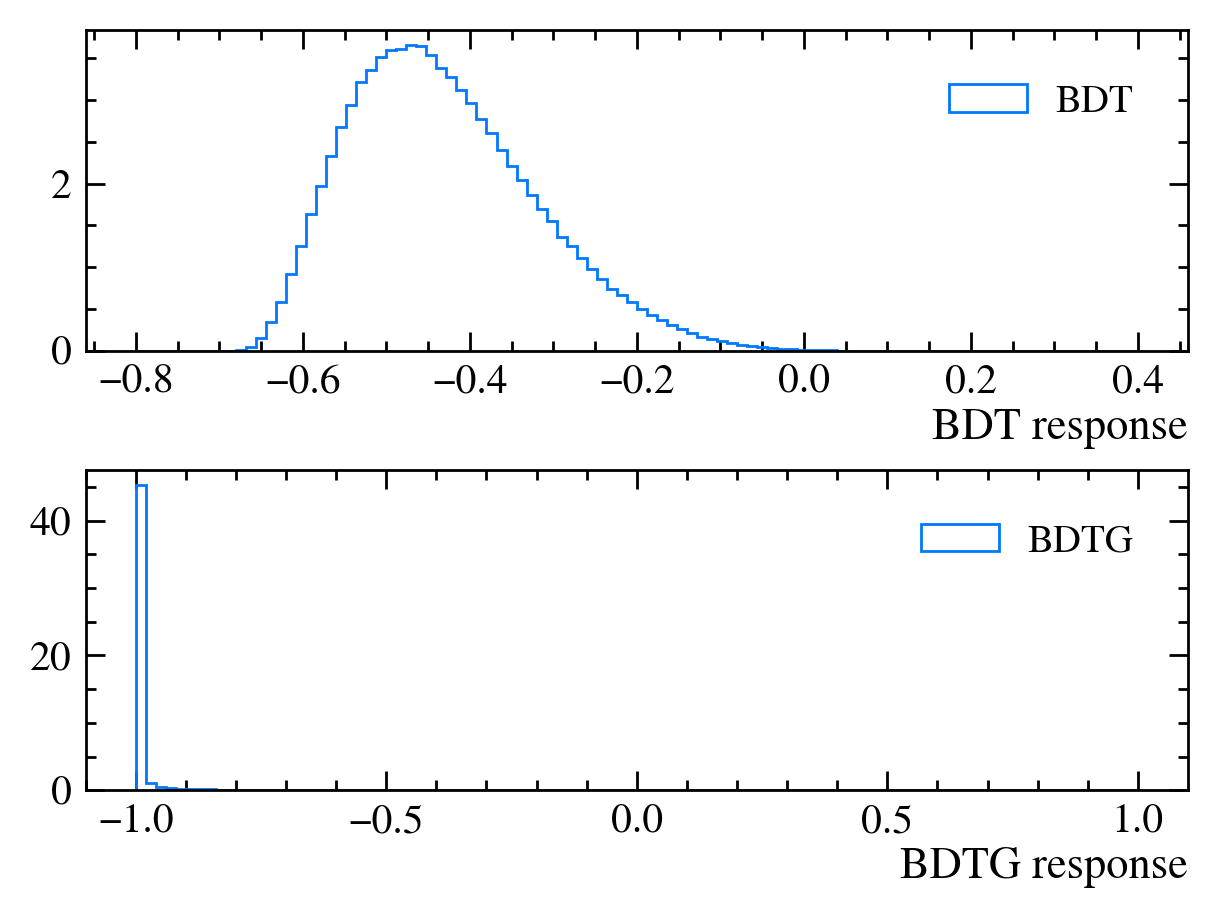

In [3]:
fig, axs = plt.subplots(2, 1)

axs[0].hist(data_df['BDT'] , bins=100, density = True, range=[-0.8, 0.4], label="BDT", histtype='step')
axs[0].set_xlabel("BDT response")
axs[0].legend()

axs[1].hist(data_df['BDTG'] , bins=100, density = True, range=[-1, 1], label="BDTG", histtype='step')
axs[1].set_xlabel("BDTG response")
axs[1].legend()

## Apply cut on data

In [4]:


Xicc_M_before_cut = data_df.Xicc_M_DTF_Lc
data_with_cuts_df = data_df.query("BDTG>0.5&abs(Lc_M-2286)<20")

Xicc_M_after_cut = data_with_cuts_df.Xicc_M_DTF_Lc

print(f'Number of events: before cut={len(Xicc_M_before_cut)} and after cut={len(Xicc_M_after_cut)}')

Number of events: before cut=947694 and after cut=3191


In [5]:
obs_min = 3500
obs_max = 3800
obs_bin_width = 5
obs_bin = int((obs_max-obs_min)/obs_bin_width)

data = Xicc_M_after_cut

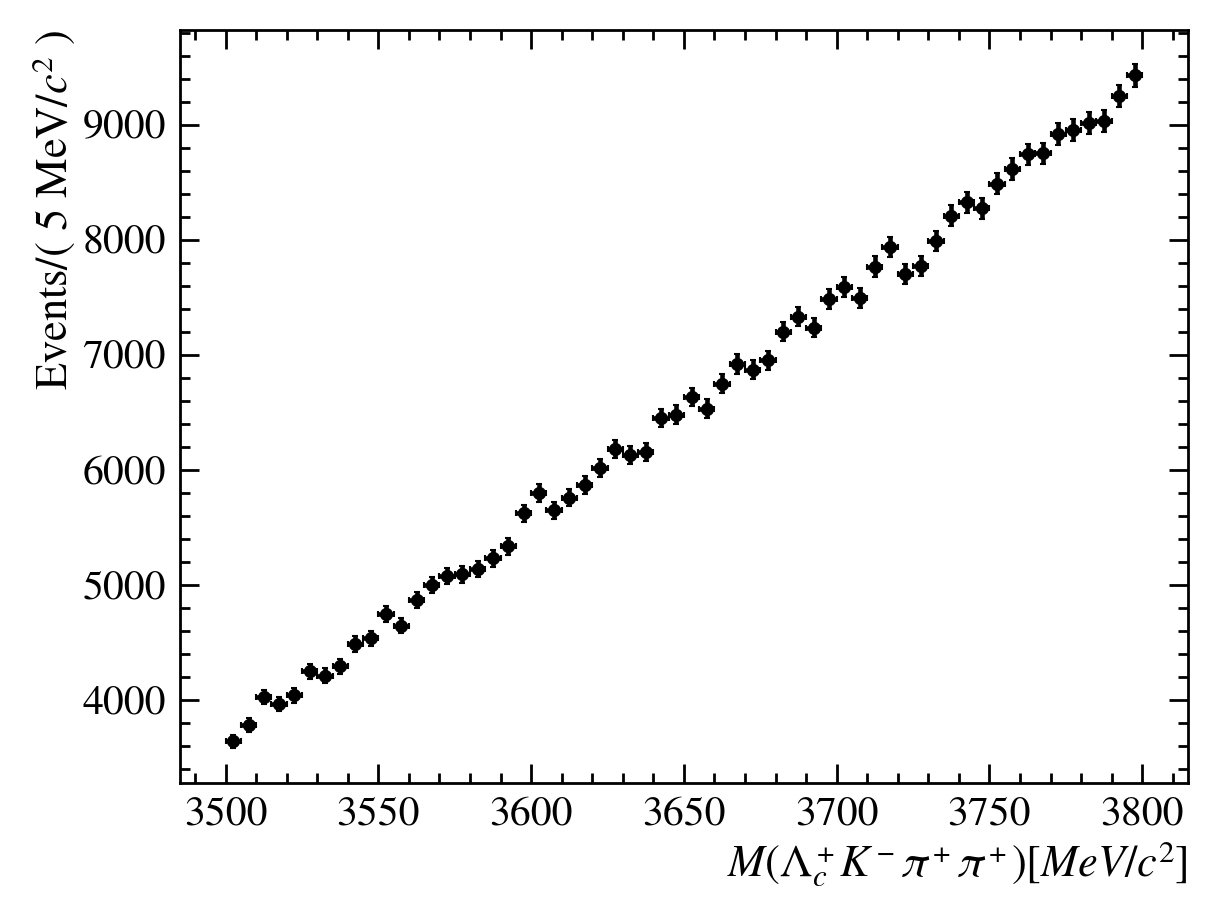

In [6]:
# visualise the data using a histogram:
def plot_data(data):
    fig, ax = plt.subplots()
    # histogram with centered bins
    histo = hist.Hist(hist.axis.Regular(obs_bin, obs_min, obs_max, label='Observable'))
    histo.fill(data)
    # errorbar histogram for the data
    ax.errorbar(histo.axes.centers[0], histo.values(), xerr=histo.axes.widths[0]/2,
            yerr=np.sqrt(histo.values()), fmt='.', label='Data', color='black')
    # labels
    #ax.set_xlabel('$m_{cand}(\Xi_{cc}^{++})[MeV/c^2]$')
    ax.set_xlabel('$M(\Lambda_c^+ K^- \pi^+ \pi^+)[MeV/c^2]$')
    ax.set_ylabel(f'Events/( {obs_bin_width} MeV/$c^2$ )')

plot_data(Xicc_M_before_cut)

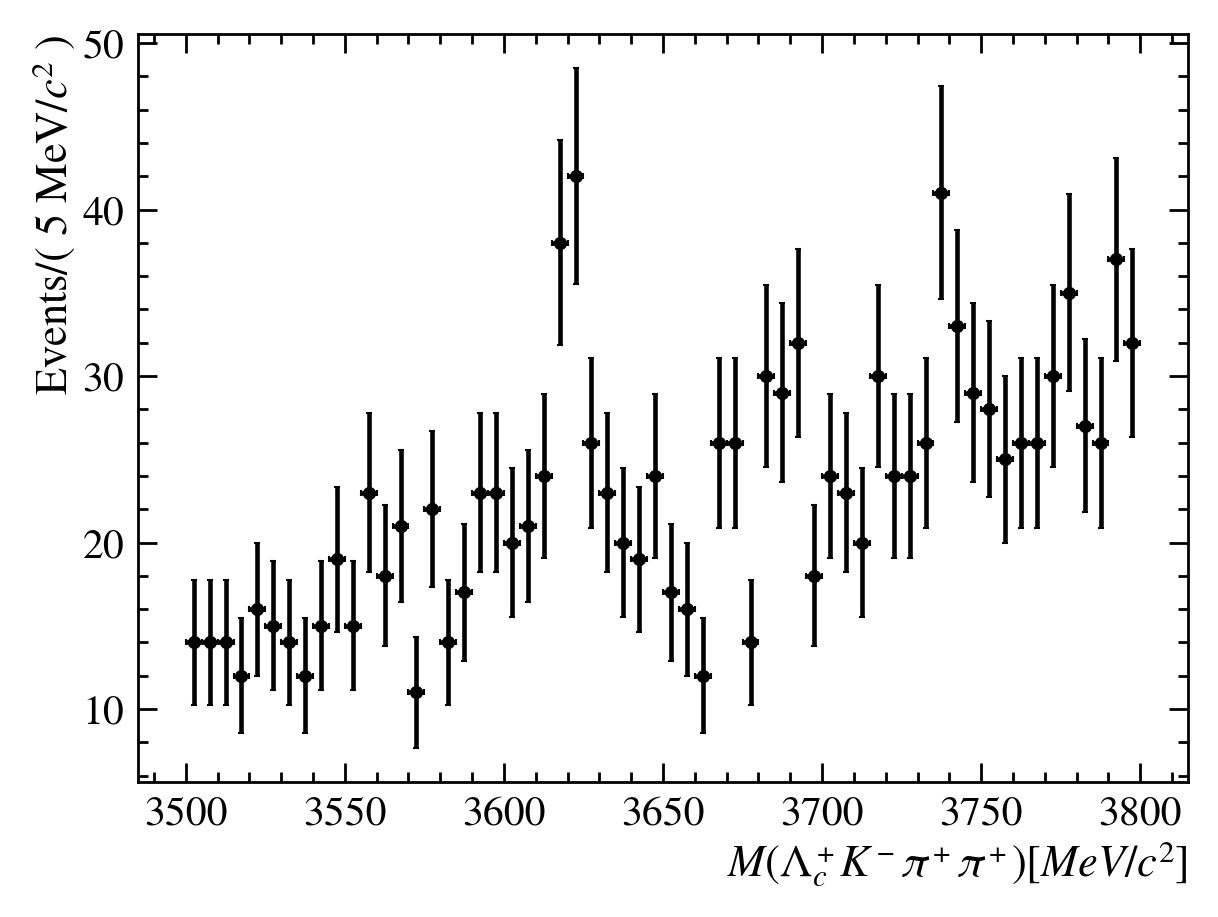

In [7]:
# alternatively you can plot the hist with the plotting api of hist
plot_data(Xicc_M_after_cut)

## Density plot before and after cut

In [8]:
def plot_mass(data, label = None, density = False, bins = obs_bin):
    h, bins = np.histogram(data, bins=bins, range=[obs_min, obs_max])
    mplhep.histplot(h, bins, density=density, yerr=True, label = label)
    plt.xlabel('$\Xi_{cc}^{++}$ mass [MeV]')
    plt.xlim(bins[0], bins[-1])

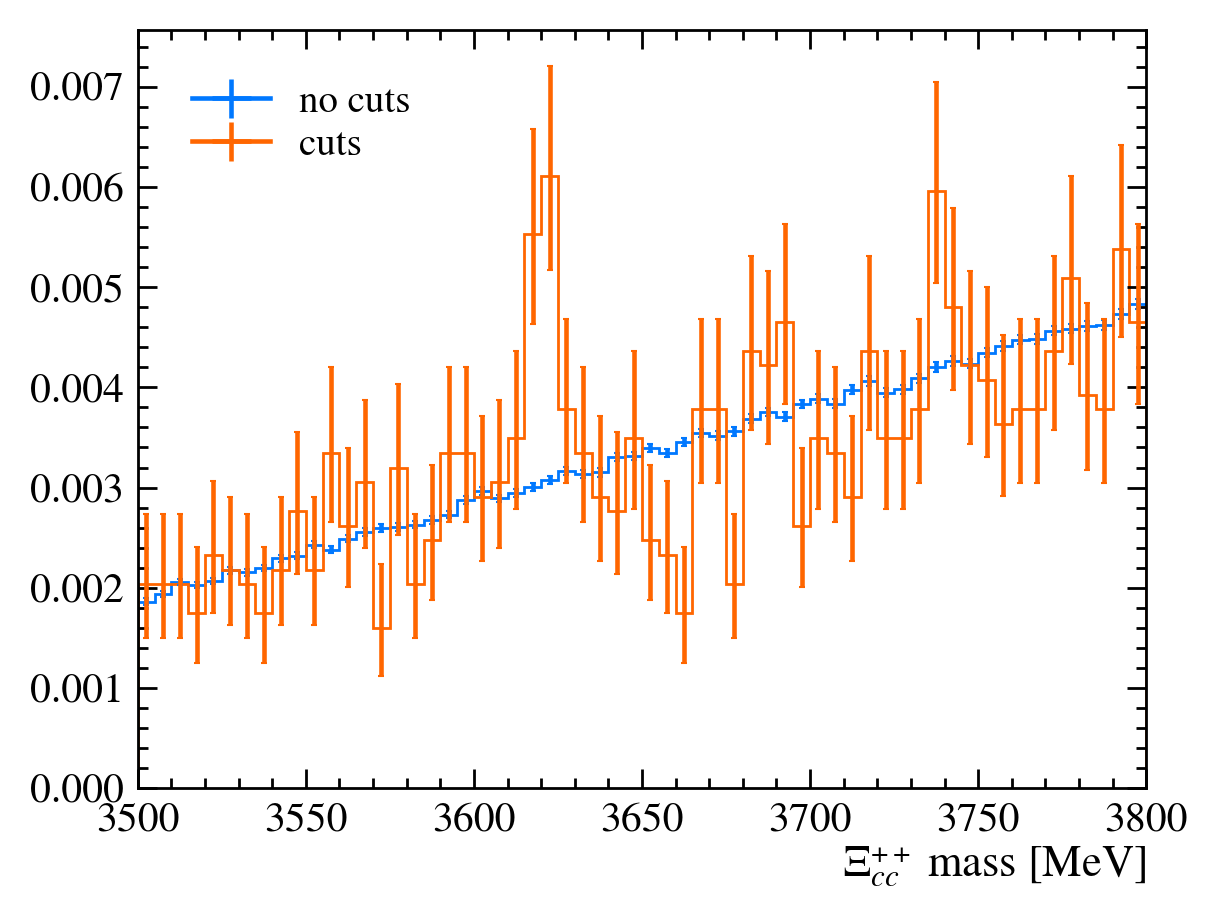

In [9]:
plot_mass(Xicc_M_before_cut , density = True , label = "no cuts")
plot_mass(Xicc_M_after_cut , density = True  , label = r"cuts" )
plt.legend(loc='best')

## Fitting Composite Models

In real life, usually the data we deal with is not described by a "simple" gaussian but also features some backgrounds that pollute the data in the signal region. 
In the case that one can make assumptions about the shape of the background distribution we can fit the combined background and signal shape to the data. 

In `zfit` this functionality is implemented by the ability to "add" up different models. It can be done with **fractions** of the respective model with respect to all or with **extended models**. Extended models are models that have a "**yield**" associated to them. 

In [10]:

data_all = data.to_numpy()

# new observable and zfit data
obs_bkg = zfit.Space('Observable with Background', limits=(obs_min, obs_max))
data_zfit = zfit.Data.from_numpy(obs=obs_bkg, array=data_all)

# parameters for signal and background shapes
mu_signal = zfit.Parameter("mu_signal", 3621, obs_min, obs_max)
sigma_signal = zfit.Parameter("sigma_signal", data.std(ddof=1), 1, 500)

# be careful and check the documentation. numpy and in zfit there are
# different definitions of the slope parameter in use! 
# numpy: exp(-x/slope) zfit: exp(slope*x)
slope_bkg = zfit.Parameter('slope_bkg', -0.4e-1, -10, 1)

# yields for an extended fit
n_signal = zfit.Parameter('n_signal', 1000, 0, 90000)
n_bkg = zfit.Parameter('n_bkg', max(0,data_zfit.n_events.numpy()-1000), -2000, 5000000)

# create the pdfs with the extended term for the yields
gaussian = zfit.pdf.Gauss(obs=obs_bkg, mu=mu_signal, sigma=sigma_signal, name='Signal')
gaussian_ext = gaussian.create_extended(n_signal)

exponential = zfit.pdf.Exponential(obs=obs_bkg, lam=slope_bkg, name='Background')
exponential_ext = exponential.create_extended(n_bkg)

# build the model as the sum of the gaussian and the exponential functions
model = zfit.pdf.SumPDF([gaussian_ext, exponential_ext])

# SumPDF with fraction instead of yield parameters
# frac = zfit.Parameter('frac', 0.5, 0.1, 0.9)
# model = zfit.pdf.SumPDF([gaussian, exponential], fracs=[frac])

# loss function is now extended unbinned NLL
nll_ext = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data_zfit)

# the minimiser
minimiser = zfit.minimize.Minuit(mode=1)

### Minimization

In [11]:
result_ext = minimiser.minimize(nll_ext)
result_ext.hesse(name='minuit_hesse')
result_ext.errors(method='minuit_minos', name='minuit_minos')
result_ext

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.core.data.Data object at 0x7fd364918430>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00053 │ 676.4181    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name            value  (rounded)    minuit_hesse         minuit_minos    at limit
------------  ------------------  --------------  -------------------  ----------
n_signal                 52.6929     +/-      12  -     12   +     13       False
n_bkg                    1322.19     +/-      38  -     37   +     38       False
mu_signal                3619.95     +/-     1.1  -    1.1   +    1.1     

In [12]:
mean = mu_signal.value().numpy()

## Plot the fitting result after cut

In [13]:
def plot_fit(dat: np.ndarray, basis: np.ndarray, model: np.ndarray, 
             obs: zfit.Space, nbins : int=obs_bin, smodel: np.ndarray=None,
             drawstyle: str='default', zmodel: zfit.pdf.BasePDF=None, title='LHCb'):
    """
    quick plotting function to visualise data and model. 
    Takes:
     - dat: (array) the data that are fitted
     - basis: (array) the points at which the model is evaluated
     - model: (array) the model that describes the data
     - obs: (zfit Space) the space in which the model lives
     - nbins: (int) the number of bins for the data histogram
     - smodel: (array) uncertainty on model (not needed)
     - drawstyle: (str) the drawstyle of plt.plot
     - zmodel: (BasePDF) for drawing submodels
    Returns:
     - None
    """
    # for normalising the pdf, scaled pdf = pdf * yield * area / bins
    limits = obs.limits 
    area = obs.area().numpy()

    # data in histogram over the full observable space
    histo = hist.Hist(hist.axis.Regular(nbins, *limits))
    histo.fill(dat)

    # the figure with an errorbar for the data and a line for the model
    fig, ax = plt.subplots()
    art_data = ax.errorbar(histo.axes.centers[0], histo.values(), 
                           xerr=histo.axes.widths[0]/2,
                           yerr=np.sqrt(histo.values()), fmt='.', 
                           label='Data', color='black', zorder=10)
    art_model = ax.plot(basis, model * area/nbins, color='darkturquoise', 
                        label='Model', zorder=8, drawstyle=drawstyle)[0]
    
    # if we have the uncertainty on the model we draw it as contour
    # and update the artist for the legend to reflect on the new model
    if smodel is not None:
        _art = ax.fill_between(basis, (model+smodel)*area/nbins, 
                               (model-smodel)*area/nbins, color='darkturquoise', 
                               alpha=0.5, zorder=-2)
        art_model = (art_model, _art)

    # define artists and labels for the legend
    artists = [art_data, art_model]
    labels = ['Data', 'Model']
    # if we want to plot the submodels of our model, we can iterate through
    # all of them and evaluate them at our basis. We will not bootstrap
    # all of their shape uncertainties though, this is just an illustration
    if hasattr(zmodel, 'get_models'):
        nmodels = len(zmodel.get_models())
        cmap = plt.get_cmap('autumn') # you can choose whatever you like. 
        norm = mpl.colors.Normalize(0, nmodels) # create a norm for the cmap
        pdfs = [(m.pdf(basis)*m.get_yield()).numpy()*area/nbins
                for m in zmodel.get_models()]
        names = [m.name.replace('_extended','') for m in zmodel.get_models()]
        labels.extend(names)
        for mdex, pdf in enumerate(pdfs):
            artists.append(ax.plot(basis, pdf, color=cmap(norm(mdex)), 
                                   linestyle='--', zorder=-1)[0])
        
    # legend and axis labels
    ax.legend(artists, labels, loc='best', 
              title=title, title_fontsize=22)
    #ax.set_xlabel('$m_{cand}(\Xi_{cc}^{++})[MeV/c^2]$')
    ax.set_xlabel('$M(\Lambda_c^+ K^- \pi^+ \pi^+)[MeV/c^2]$')
    ax.set_ylabel(f'Events/( {obs_bin_width} MeV/$c^2$ )');

#plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, smodel=smodel_pdf_np, zmodel=model)


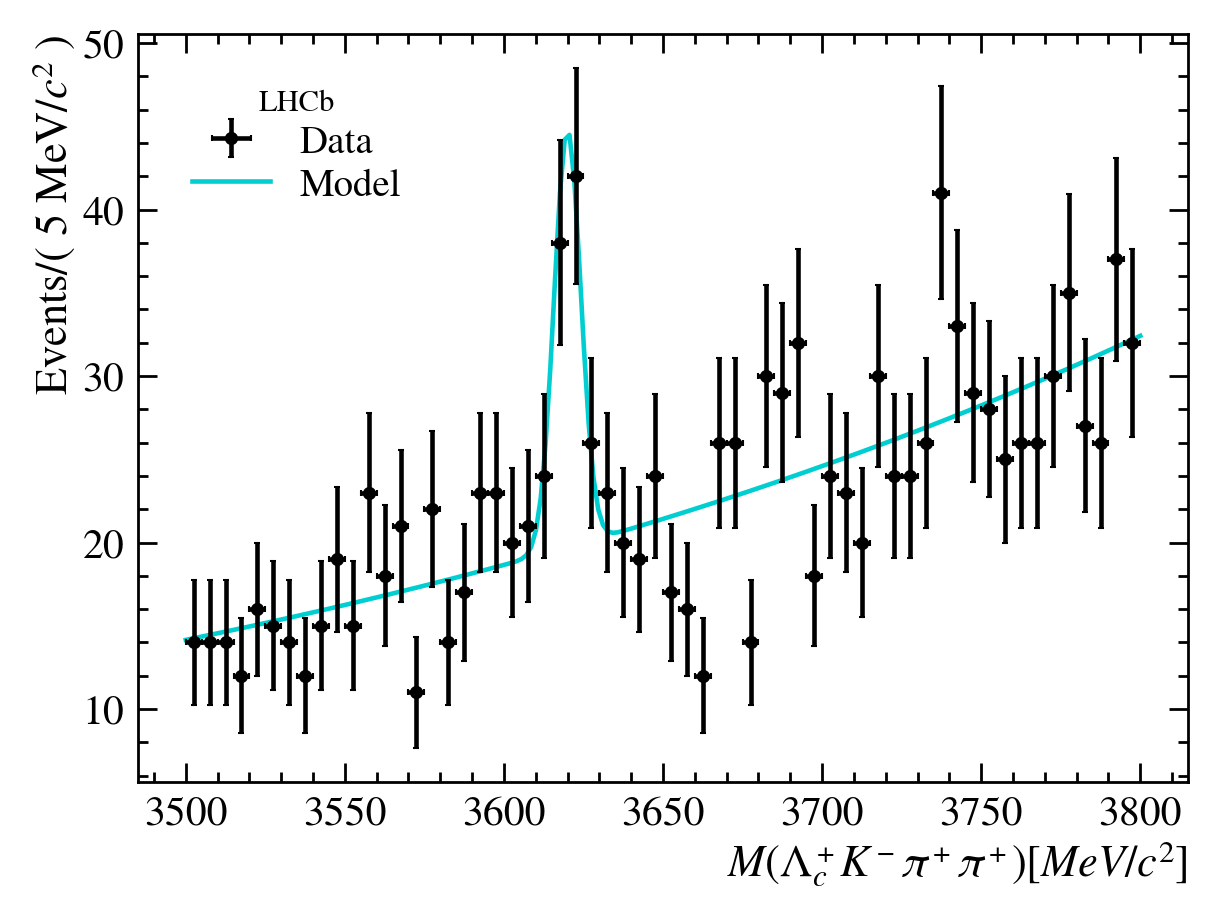

In [14]:
# visualise as we have discussed before
# with the addition of this helper function for the uncertainties
def eval_zfit_model(model: zfit.pdf.BasePDF, basis:np.ndarray, pars: np.ndarray)->np.ndarray:
    """ brief helper to evaluate model for given parameters and basis """
    with zfit.param.set_values([n_signal, n_bkg, mu_signal, sigma_signal, slope_bkg], pars):
        pdf = model.pdf(basis) * (n_signal.numpy()+n_bkg.numpy())
    return pdf

# the model as the sum of the individual pdfs
basis_pdf = np.linspace(obs_min, obs_max, 200)
model_pdf_np = model.pdf(basis_pdf).numpy() * (n_signal.numpy()+n_bkg.numpy())

# the uncertainty computation on our model given the parameters
mean_params = [result_ext.params[p]['value'] for p in result_ext.params.keys()]
covariance = result_ext.covariance()
rnd_pars = gen.multivariate_normal(mean_params, covariance, 200,)
smodel_pdf_np = np.std([eval_zfit_model(model, basis_pdf, pars) for pars in rnd_pars], ddof=1, axis=0)

# plotting all together
plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg)#, smodel=smodel_pdf_np)

With just a few modifications to the plotting script we can also visualise the sub-models of our composed model: 

In [15]:
print([m for m in model.get_models()])

[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu_signal, sigma_signal], <zfit.<class 'zfit.models.basic.Exponential'>  params=[slope_bkg]]


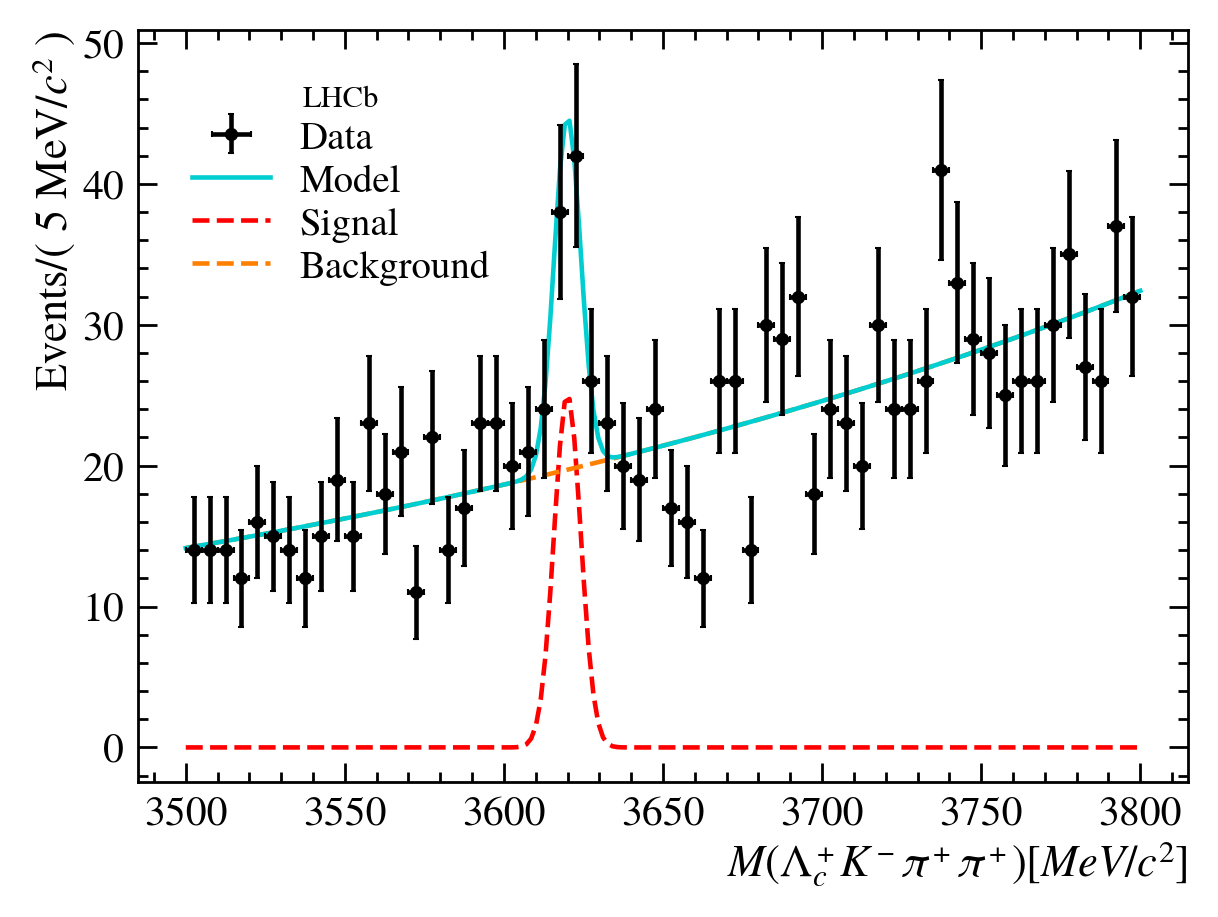

In [16]:
plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, zmodel=model)

## Fitting before cut



In [17]:
data_all = Xicc_M_before_cut.to_numpy()

# new observable and zfit data
obs_bkg_before = zfit.Space('Observable with Background', limits=(obs_min, obs_max))
data_zfit_before = zfit.Data.from_numpy(obs=obs_bkg_before, array=data_all)

# parameters for signal and background shapes
mu_before = zfit.Parameter("mu_before", (obs_min+obs_max)/2, obs_min, obs_max)
sigma_before = zfit.Parameter("sigma_before", Xicc_M_before_cut.std(ddof=1), 5, 500)

# be careful and check the documentation. numpy and in zfit there are
# different definitions of the slope parameter in use! 
# numpy: exp(-x/slope) zfit: exp(slope*x)
slope_bkg_before = zfit.Parameter('slope_bkg_before', -0.4e-1, -10, 1)

# yields for an extended fit
n_signal_before = zfit.Parameter('n_signal_before', 50000, 0, 90000)
n_bkg_before = zfit.Parameter('n_bkg_before', data_zfit_before.n_events.numpy()-50000, 0, 5000000)

# create the pdfs with the extended term for the yields
gaussian_before = zfit.pdf.Gauss(obs=obs_bkg_before, mu=mu_before, sigma=sigma_before, name='Signal')
gaussian_ext_before = gaussian_before.create_extended(n_signal_before)

exponential_before = zfit.pdf.Exponential(obs=obs_bkg_before, lam=slope_bkg_before, name='Background')
exponential_ext_before = exponential_before.create_extended(n_bkg_before)

# build the model as the sum of the gaussian and the exponential functions
model_before = zfit.pdf.SumPDF([gaussian_ext_before, exponential_ext_before])

nll_ext_before = zfit.loss.ExtendedUnbinnedNLL(model=model_before, data=data_zfit_before)

ValueError: Setting value 3.334305792051821e+36 invalid for parameter sigma_before with limits 5.0 - 500.0. This is changed. In order to silence this and clip the value, you can use (with caution, advanced) `Parameter.assign`

In [ ]:
result_ext = minimiser.minimize(nll_ext_before)
result_ext.hesse(name='minuit_hesse')
result_ext.errors(method='minuit_minos', name='minuit_minos')
result_ext

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_4, Composed_autoparam_5]] data=[<zfit.core.data.Data object at 0x7f593e3eecd0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.4e-05 │ -28498.18   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name                value  (rounded)    minuit_hesse         minuit_minos    at limit
----------------  ------------------  --------------  -------------------  ----------
n_signal_before              10352.2     +/- 1.7e+02  -1.7e+02   +1.7e+02       False
n_bkg_before                 73997.8     +/- 3.1e+02  -3.1e+02   +3.1e+02       False
mu_before                    3624.23     +/-    0.18  -   

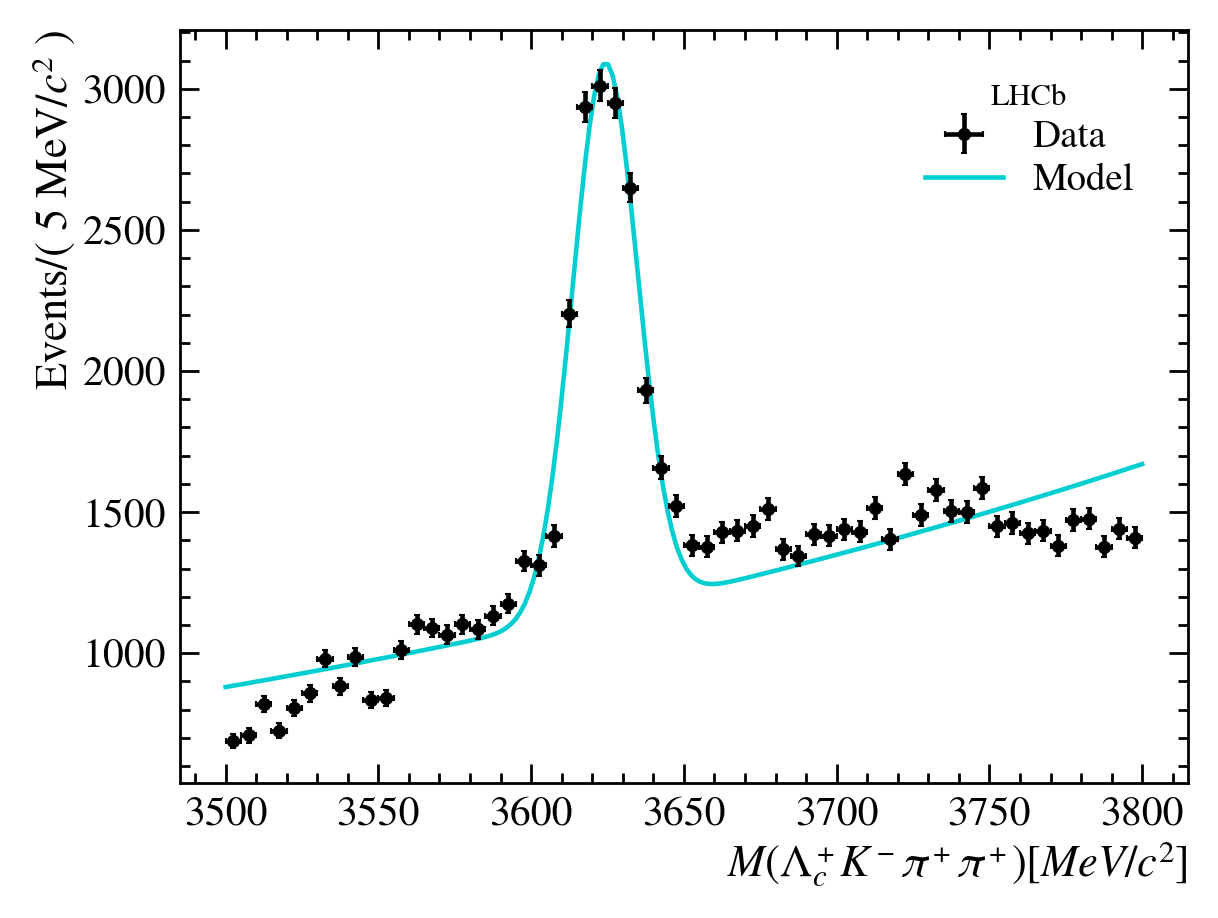

In [ ]:
# the model as the sum of the individual pdfs
basis_pdf_before = np.linspace(obs_min, obs_max, 200)
model_pdf_np_before = model_before.pdf(basis_pdf_before).numpy() * (n_signal_before.numpy()+n_bkg_before.numpy())

plot_fit(data_all, basis_pdf_before, model_pdf_np_before, obs_bkg_before)

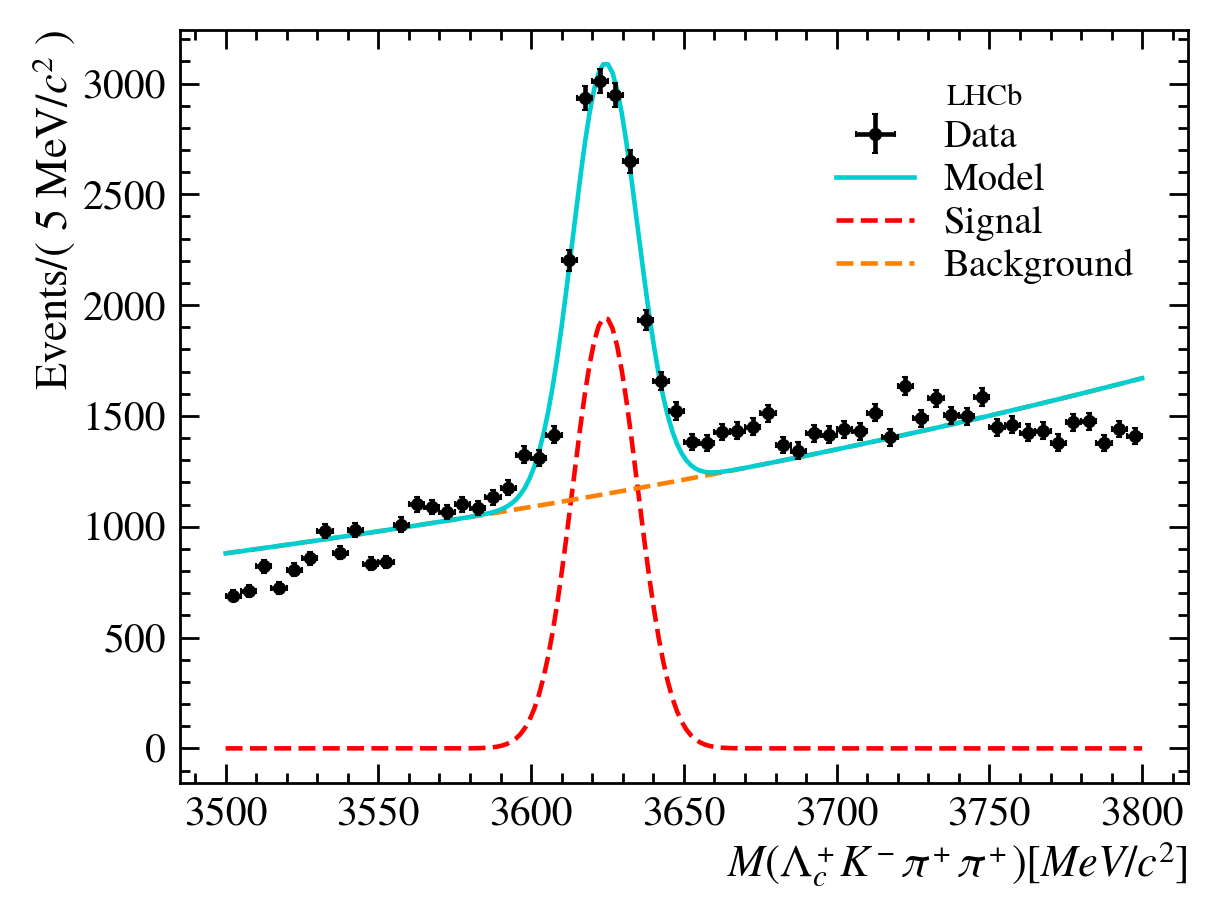

In [ ]:
plot_fit(data_all, basis_pdf_before, model_pdf_np_before, obs_bkg_before, zmodel=model_before)